# Select dispatching rules using neural networks

This notebook presents an implementation of a neural network for dynamically selecting dispatching rules based on the system state.

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import time
import sys
import shap
import pandas as pd
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from joblib import dump, load
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from time import mktime

tqdm.pandas()

sys.path.append("..")
from src.models import train_pipeline_model, evaluate_pipeline,  optimize_hyperparameters, plot_learning_curve
from src.utils import get_hyperparameter_number
from src.simulation import assign_priority_edd, assign_priority_mdd, assign_priority_spt, assign_priority_srpt, \
    assign_priority_lpt, assign_priority_cr, assign_priority_ds, assign_priority_fifo, run_simulation_complete

## Get required data

In [2]:
# Load the training data
with open(r"../data/processed/data_processed_classification_training.pickle", "rb") as output_file:
    data_train = pickle.load(output_file)

In [3]:
# Load the validation data
with open(r"../data/processed/data_processed_classification_validation.pickle", "rb") as output_file:
    data_validation = pickle.load(output_file)

In [4]:
# Load data required for simulation
product_types_df = pd.read_csv("../data/external/product_types.csv")
product_types_df = product_types_df[product_types_df.id != 2]
with open(r"../data/interim/sim_data.pickle", "rb") as output_file:
    orders_df = pickle.load(output_file)
machines_df = pd.read_csv("../data/external/machine.csv")
machines_df = machines_df[machines_df.product_type_id != 2]

## Define constants

In [5]:
# Define constants for model training
RANDOM_STATE = 42
numeric_features = list(data_train.columns)
numeric_features.remove("priority_rule_start")
numeric_features.remove("priority_rule_score")
categorical_features =  ["priority_rule_start"]

In [6]:
# Define constants for simulation
priority_rules = {"edd": assign_priority_edd,
                  "spt": assign_priority_spt,
                  "srpt": assign_priority_srpt,
                  "fifo": assign_priority_fifo,
                  "cr": assign_priority_cr,
                  "mdd": assign_priority_mdd,
                  "lpt": assign_priority_lpt,
                  "ds": assign_priority_ds}
SIMULATION_START = mktime(datetime(2022, 11, 14, 5, 0, 0).timetuple()) * 1000
due_date_range_list = [(3, 10), (5, 14), (7, 21)]
number_orders_start_list = [80, 90, 100, 110]
average_count_new_orders_list = [80, 90, 100, 110]
worker_list =  [40, 50, 60, 70]
random_states = [100, 101, 102]

# Prepare data

In [7]:
# Define features and flag
X = data_train.drop("priority_rule_score",  axis = 1)
y = data_train[["priority_rule_score"]]
X_validate = data_validation.drop("priority_rule_score",  axis = 1)
y_validate = data_validation[["priority_rule_score"]]

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Model training

## Baseline

In [9]:
# Simple dummy classifier based on the maximization of the prior probability
dummy = DummyClassifier(strategy="prior", random_state=42)
dummy_fit = dummy.fit(X_train, y_train)
print(f"Accuracy of the dummy classifier is: {round(dummy_fit.score(X_test, y_test), 4)}")

Accuracy of the dummy classifier is: 0.2418


In [10]:
# Simple logistic regression baseline without hyperparameter tuning and feature selection
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1)
pipeline_lr = train_pipeline_model(lr, X_train, y_train, numeric_features, categorical_features)
evaluate_pipeline(pipeline_lr, X_test, y_test)

Start at 11:5:48
Duration: 12.301319122314453
Start at 11:6:0
Accuracy: 0.46142578125
F1: 0.43263465330364026
Precision: 0.44603803103803535
Recall: 0.42746990199377655
Duration: 0.19478297233581543


## Hyperparameter search

In [11]:
# Define set of hyperparameters
params_mlp = {"classifier__activation": ["identity", "logistic", "tanh", "relu"],
             "classifier__solver": ["lbfgs", "sgd", "adam"],
             "classifier__alpha": [0.0001, 0.05],
             "classifier__max_iter": [1000, 2000, 5000, 10000],
             "classifier__early_stopping": [True, False],
             "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
             "classifier__hidden_layer_sizes": [(20), (20, 20), (20, 20, 20), (50), (50,20), (50,50), (100)]
            }
print(f"Set of {get_hyperparameter_number(params_mlp)} hyperparameters")

Set of 4032 hyperparameters


Based on the variables we executed a grid hyperparameter search using successful halving.

In [12]:
# Fit hyperparameter search
model = MLPClassifier(random_state = RANDOM_STATE)
feature_selector = None
# fitted_clf = optimize_hyperparameters(X_train, y_train, model, feature_selector,numeric_features, categorical_features, params_mlp, RANDOM_STATE)
# print(fitted_clf.best_params_)
# pd.DataFrame(fitted_clf.cv_results_).to_csv("../data/processed/hyperparameter_search/results_hyperparameter_neural_network_classification.csv", index = False)

The grid search was executed and took 36222.24 seconds. The results are saved in a dataframe and can be read in as a csv file.

In [13]:
# Load results from hyperparameter optimization
results_hyperparameter = pd.read_csv("../data/processed/hyperparameter_search/results_hyperparameter_neural_network_classification.csv")

The resulting set of optimal hyperparameter were:
**Neural Network**
* max_iter=1000
* solver="adam"
* learning_rate="invscaling"
* early_stopping=False
* hidden_layer_sizes=50
* alpha=0.05
* activation="relu"


## Train final model

Train model for evaluation based on the select hyperparameter.

In [14]:
# Train pipeline based on hyperparameter
# Duration ~ 2 minutes
final_model = MLPClassifier(random_state=RANDOM_STATE, max_iter=1000, solver="adam", learning_rate="invscaling", early_stopping=False, hidden_layer_sizes=50, alpha=0.05, activation="relu")
final_feature_selector = None
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)

In [15]:
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_neural_network_training.joblib')

In [16]:
# Load trained model
pipeline_trained = load('../models/pipeline_dispatching_classification_neural_network_training.joblib')

## Model evaluation

In [17]:
# Evaluate pipeline on train
evaluate_pipeline(pipeline_trained, X_train, y_train)

Start at 11:6:0
Accuracy: 0.6076253255208334
F1: 0.5820048069663489
Precision: 0.5852104169603649
Recall: 0.5807199624878743
Duration: 0.6914310455322266


In [18]:
# Evaluate pipeline on test
evaluate_pipeline(pipeline_trained, X_test, y_test)

Start at 11:6:1
Accuracy: 0.5877821180555556
F1: 0.5613160770900909
Precision: 0.5646342716449885
Recall: 0.5603015004781242
Duration: 0.25450587272644043


We can already see that the model quality sinks signicantly which shows overfitting of the model on the training dataset.

In [19]:
# Plot learning curve based on data samples and fitting time
# May take some seconds to calculate
# plot_learning_curve(
#         pipeline_trained,
#        "Evaluation training set Neural Network",
#        X,
#        y.values.ravel(),
#        axes=None,
#        ylim=None,
#        cv=None,
#        n_jobs=-1,
#        scoring="accuracy",
#        train_sizes=np.linspace(0.1, 1.0, 5))

We can see that with increasing data the gap in between training and test is closing and the performance is increasing. More data could help here to improve the models further.

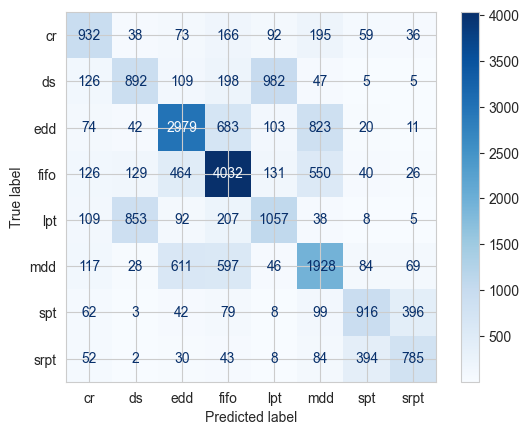

In [20]:
# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(
        pipeline_trained,
        X_validate,
        y_validate,
        cmap=plt.cm.Blues)

In [21]:
# Get feature names
# feature_names = pipeline_trained["preprocessor"].get_feature_names_out(X_validate.columns)

In [22]:
# Calculate importance
# Duration ~ 90 minutes
# importance = permutation_importance(pipeline_trained, X_validate, y_validate,
#                            n_repeats=100,
#                            random_state=0)

In [23]:
# Visualize result
# fig, ax = plt.subplots()
# indices = importance['importances_mean'].argsort()[0:20]
# plt.barh(range(len(indices)),
#              importance['importances_mean'][indices],
#              xerr=importance['importances_std'][indices])
#
# ax.set_yticks(range(len(indices)))
# _ = ax.set_yticklabels(feature_names[indices])

## Train full model

Train the full model based on all available data.

In [24]:
# Create combined dataset for training the final model
X_complete = pd.concat([X, X_validate])
y_complete = pd.concat([y, y_validate])

In [25]:
# Train pipeline based on hyperparameter
# Duration ~ 2 minutes
final_model = MLPClassifier(random_state=RANDOM_STATE, max_iter=1000, solver="adam", learning_rate="invscaling", early_stopping=False, hidden_layer_sizes=50, alpha=0.05, activation="relu")
final_feature_selector = None
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_neural_network_complete.joblib')

In [26]:
# Load trained model
pipeline_simulation = load('../models/pipeline_dispatching_classification_neural_network_complete.joblib')

# Evaluation in simulation environment

In this section we define a simulation testing environment for testing and comparing the performance of different approaches. For this we create use repeated simulation of a factory with varying experiment settings. The trained algorithm are then used in the process to select dispatching rules.

In [27]:
# Execute simulation
# Duration ~ 9 minutes
# simulation_results = run_simulation_complete(pipeline_simulation, priority_rules, random_states, due_date_range_list,
#                                             number_orders_start_list,
#                                             average_count_new_orders_list, worker_list, "Neural Network Classification",
#                                             product_types_df, machines_df, orders_df, SIMULATION_START)

In [28]:
# Save simulation results
# simulation_results.to_csv("../data/processed/evaluation/simulation_results_validation_classification_neural_network.csv", index = False)

In [29]:
# Load simulation results
simulation_results = pd.read_csv("../data/processed/evaluation/simulation_results_validation_classification_neural_network.csv")

In [30]:
# Analyse simulation results profit
simulation_results["profit"] = simulation_results["revenue"] - simulation_results["penalty"]
print(f"Average profit is: {simulation_results.profit.mean()}")

Average profit is: 7002.596305467477


<AxesSubplot: xlabel='day', ylabel='profit'>

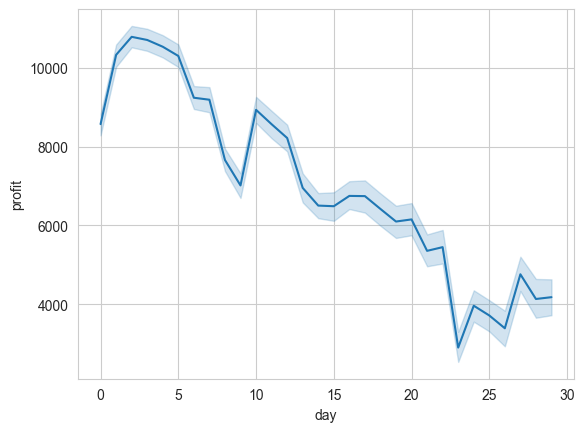

In [31]:
# Visualize profit
sns.lineplot(simulation_results, x = "day", y = "profit")

<AxesSubplot: xlabel='day', ylabel='profit'>

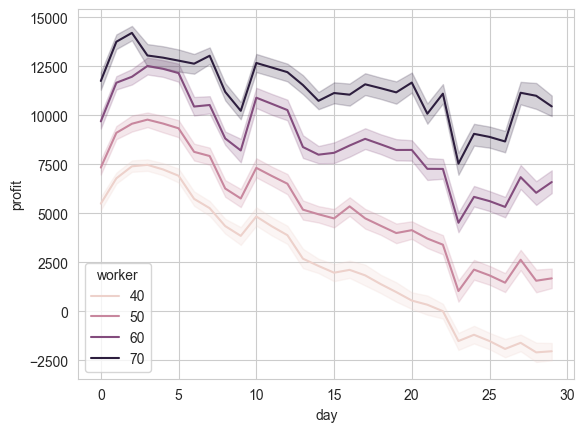

In [32]:
# Visualize profit per worker constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "worker")

<AxesSubplot: xlabel='day', ylabel='profit'>

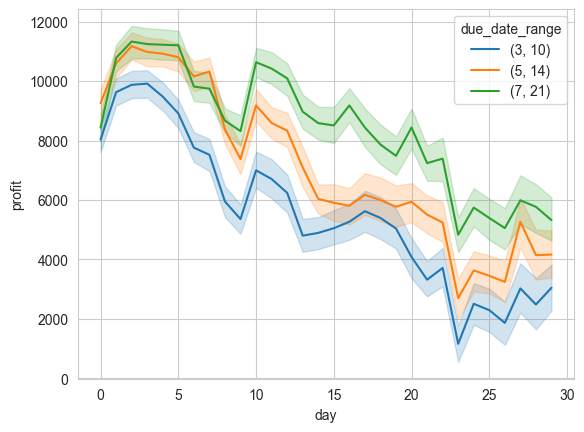

In [33]:
# Visualize profit per due date constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "due_date_range")

<AxesSubplot: xlabel='day', ylabel='profit'>

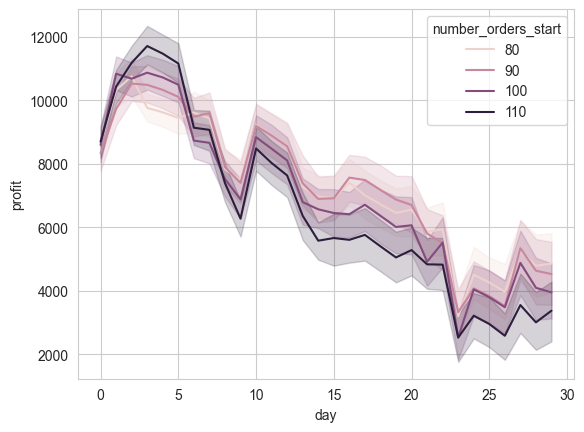

In [34]:
# Visualize profit per number_orders_start constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "number_orders_start")

<AxesSubplot: xlabel='day', ylabel='profit'>

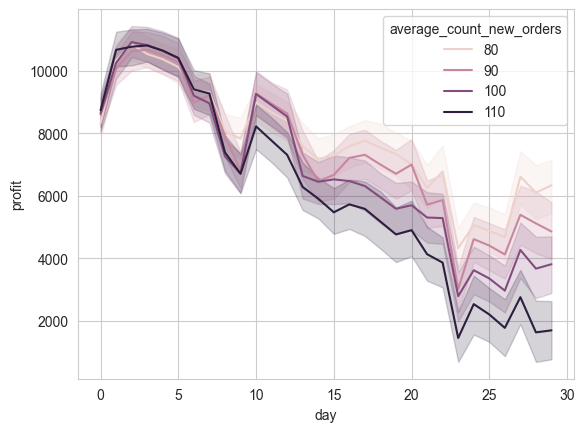

In [35]:
# Visualize profit per average count new orders constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "average_count_new_orders")